# 1/15/21 - Starting a master notebook that covers all the steps conducted in previous notebooks.

In [1]:
# libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from astropy import constants as const
from astropy.io import fits
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM, z_at_value

c = const.c.to('km/s').value #c in km/s
h0 = 73.8 #h0 in km/(Mpc*s) Riess2011
cosmo = FlatLambdaCDM(h0, Om0=0.262)

# paths
csv_path = '/data/sknabel/autoz_lens_model/files/csv/'
latest_path= f'{csv_path}latest/'
png_path = '/data/sknabel/autoz_lens_model/visuals/png/'
knabel2020_file_path = '/data/sknabel/lens_methods/files/'

In [2]:
# load autoz csv
autoz = pd.read_csv(f'{csv_path}autoz.csv')
print(len(autoz))

166332


In [3]:
# load catalogs from LinKS, Li, and Zoo

# load LinKS files from Knabel-2020 (initial and final selections, should be 421 and 47)
links_initial_data = pd.read_csv(f'{knabel2020_file_path}mac_in_gama_withgamaid.csv')
print(len)
# drop null values, objects that didn't match the gama catalog
links = links_initial_data.dropna(axis=0, subset=['GAMA_ID'])
# load the selection from Knabel-2020
links_knabel = pd.read_csv(f'{knabel2020_file_path}mac_latest.csv')

# load Li-2020 files
li_data = pd.read_csv(f'{csv_path}li_match_to_gama_spec.csv')
# drop 0 values, objects that didn't match the gama catalog
li_data.GAMA_ID.replace(0, np.nan, inplace=True)
li = li_data.dropna(axis=0, subset=['GAMA_ID'])

# load Zoo files
zoo = pd.read_csv(f'{knabel2020_file_path}zoo_latest.csv')

print(len(links), len(links_knabel), len(li), len(zoo))

<built-in function len>
305 47 32 13


In [4]:
# merge links catalogs with autoz

links_autoz = pd.merge(links, autoz, how = 'left', on = 'GAMA_ID')
links_knabel_autoz = pd.merge(links_knabel, autoz, how = 'left', on = 'GAMA_ID')
li_autoz = pd.merge(li, autoz, how = 'left', on = 'GAMA_ID')
zoo_autoz = pd.merge(zoo, autoz, how = 'left', on = 'GAMA_ID')

print(len(links_autoz), len(links_knabel_autoz), len(li_autoz), len(zoo_autoz))

348 51 37 13


### Template matches are given as cross-correlation peaks given by their sigma value, with up to four matches.
### We want sigmas 1 and 2 to be significantly higher than sigmas 3 and 4, showing a double spectral profile.
### $R = \sigma_2/\sqrt{(\sigma_3)^2/2+(\sigma_4)^2/2}$

In [5]:
# Select based on R > 1.2
links_select = links_autoz[links_autoz.R > 1.2]
links_knabel_select = links_knabel_autoz[links_knabel_autoz.R > 1.2]
li_select = li_autoz[li_autoz.R > 1.2]
zoo_select = zoo_autoz[zoo_autoz.R > 1.2]
print(len(links_select), len(links_knabel_select), len(li_select), len(zoo_select))

59 7 8 0


Text(0.5, 1.0, 'Selection Based on $\\sigma$ and R Values')

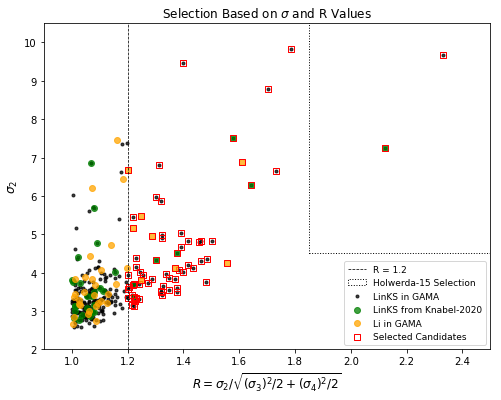

In [6]:
# visualize selection

fig = plt.figure(figsize=(8,6))
ax = plt.subplot()
ax.set_xlim(0.9, 2.5)
ax.set_ylim(2.0, 10.5)
ax.scatter(links_autoz.R,
          links_autoz.sigma2,
          color = 'k',
          marker = '.',
          alpha = 0.75,
          label = 'LinKS in GAMA')
ax.scatter(links_knabel_autoz.R,
           links_knabel_autoz.sigma2,
          color = 'g',
          marker = 'o',
          alpha = 0.75,
          label = 'LinKS from Knabel-2020')
ax.scatter(links_select.R,
          links_select.sigma2,
          facecolor= 'none',
          marker = 's',
          edgecolor = 'r',
          label = '_Selected Candidates')
ax.scatter(li_autoz.R,
           li_autoz.sigma2,
          color = 'orange',
          marker = 'o',
          alpha = 0.75,
          label = 'Li in GAMA')
ax.scatter(li_select.R,
          li_select.sigma2,
          facecolor= 'none',
          marker = 's',
          edgecolor = 'r',
          label = 'Selected Candidates')
ax.add_patch(patches.Rectangle((1.85, 4.5), 2, 10, 
                               edgecolor = 'k', facecolor = 'none', linestyle = ':',
                              label = 'Holwerda-15 Selection'))
ax.axvline(1.2, color = 'k', linewidth = .75, linestyle = '--', label = 'R = 1.2')
plt.legend(fontsize=9)
ax.set_xlabel('$R = \sigma_2/\sqrt{(\sigma_3)^2/2+(\sigma_4)^2/2}$', fontsize = 12)
ax.set_ylabel('$\sigma_2$',  fontsize = 12)
ax.set_title('Selection Based on $\sigma$ and R Values')
#plt.show()

#plt.savefig('/home/shawn/Desktop/links_autoz/visuals/png/sigma_selection062020.png')

In [61]:
# designate template types (positions of ELGs and/or PGs)
#########
# links
pg_elg1 = links_select[(links_select.z1 < links_select.z2) & (links_select.template1 >=40) & (links_select.template1 <= 42) 
             & (links_select.template2 > 42) & (links_select.template2 <= 47)]
pg_elg2 = links_select[(links_select.z1 > links_select.z2) & (links_select.template2 >=40) & (links_select.template2 <= 42)
             & (links_select.template1 > 42) & (links_select.template1 <= 47)]

pg_elg = pd.concat([pg_elg1, pg_elg2])
pg_elg['type'] = 'PG + ELG'
pg_elg['type_number'] = 1
print(len(pg_elg))

elg_pg1 = links_select[(links_select.z1 < links_select.z2) & (links_select.template2 >=40) & (links_select.template2 <= 42)
             & (links_select.template1 > 42) & (links_select.template1 <= 47)]
elg_pg2 = links_select[(links_select.z1 > links_select.z2) & (links_select.template1 >=40) & (links_select.template1 <= 42)
             & (links_select.template2 > 42) & (links_select.template2 <= 47)]

elg_pg = pd.concat([elg_pg1, elg_pg2])
elg_pg['type'] = 'ELG + PG'
elg_pg['type_number'] = 2
print(len(elg_pg))

elg_elg = links_select[(links_select.template2 >= 40) & (links_select.template2 <= 42) & (links_select.template1 >=40 ) & (links_select.template1 <= 42)]
elg_elg['type'] = 'ELG + ELG'
elg_elg['type_number'] = 3
pg_pg = links_select[(links_select.template1 > 42) & (links_select.template2 <= 47) & (links_select.template2 > 42) & (links_select.template2 <= 47)]
pg_pg['type'] = 'PG + PG'
pg_pg['type_number'] = 4
print(len(elg_elg))
print(len(pg_pg))

links_select_types = pd.concat([pg_elg, elg_pg, elg_elg, pg_pg])
print(f'links_select: {len(links_select_types)}')

##########
#links_knabel
pg_elg1 = links_knabel_select[(links_knabel_select.z1 < links_knabel_select.z2) & (links_knabel_select.template1 >=40) & (links_knabel_select.template1 <= 42) 
             & (links_knabel_select.template2 > 42) & (links_knabel_select.template2 <= 47)]
pg_elg2 = links_knabel_select[(links_knabel_select.z1 > links_knabel_select.z2) & (links_knabel_select.template2 >=40) & (links_knabel_select.template2 <= 42)
             & (links_knabel_select.template1 > 42) & (links_knabel_select.template1 <= 47)]

pg_elg = pd.concat([pg_elg1, pg_elg2])
pg_elg['type'] = 'PG + ELG'
pg_elg['type_number'] = 1
print(len(pg_elg))

elg_pg1 = links_knabel_select[(links_knabel_select.z1 < links_knabel_select.z2) & (links_knabel_select.template2 >=40) & (links_knabel_select.template2 <= 42)
             & (links_knabel_select.template1 > 42) & (links_knabel_select.template1 <= 47)]
elg_pg2 = links_knabel_select[(links_knabel_select.z1 > links_knabel_select.z2) & (links_knabel_select.template1 >=40) & (links_knabel_select.template1 <= 42)
             & (links_knabel_select.template2 > 42) & (links_knabel_select.template2 <= 47)]

elg_pg = pd.concat([elg_pg1, elg_pg2])
elg_pg['type'] = 'ELG + PG'
elg_pg['type_number'] = 2
print(len(elg_pg))

elg_elg = links_knabel_select[(links_knabel_select.template2 >= 40) & (links_knabel_select.template2 <= 42) & (links_knabel_select.template1 >=40 ) & (links_knabel_select.template1 <= 42)]
elg_elg['type'] = 'ELG + ELG'
elg_elg['type_number'] = 3
pg_pg = links_knabel_select[(links_knabel_select.template1 > 42) & (links_knabel_select.template2 <= 47) & (links_knabel_select.template2 > 42) & (links_knabel_select.template2 <= 47)]
pg_pg['type'] = 'PG + PG'
pg_pg['type_number'] = 4
print(len(elg_elg))
print(len(pg_pg))

links_knabel_select_types = pd.concat([pg_elg, elg_pg, elg_elg, pg_pg])
print(f'links_knabel_select: {len(links_knabel_select_types)}')
#############
#li
pg_elg1 = li_select[(li_select.z1 < li_select.z2) & (li_select.template1 >=40) & (li_select.template1 <= 42) 
             & (li_select.template2 > 42) & (li_select.template2 <= 47)]
pg_elg2 = li_select[(li_select.z1 > li_select.z2) & (li_select.template2 >=40) & (li_select.template2 <= 42)
             & (li_select.template1 > 42) & (li_select.template1 <= 47)]

pg_elg = pd.concat([pg_elg1, pg_elg2])
pg_elg['type'] = 'PG + ELG'
pg_elg['type_number'] = 1
print(len(pg_elg))

elg_pg1 = li_select[(li_select.z1 < li_select.z2) & (li_select.template2 >=40) & (li_select.template2 <= 42)
             & (li_select.template1 > 42) & (li_select.template1 <= 47)]
elg_pg2 = li_select[(li_select.z1 > li_select.z2) & (li_select.template1 >=40) & (li_select.template1 <= 42)
             & (li_select.template2 > 42) & (li_select.template2 <= 47)]

elg_pg = pd.concat([elg_pg1, elg_pg2])
elg_pg['type'] = 'ELG + PG'
elg_pg['type_number'] = 2
print(len(elg_pg))

elg_elg = li_select[(li_select.template2 >= 40) & (li_select.template2 <= 42) & (li_select.template1 >=40 ) & (li_select.template1 <= 42)]
elg_elg['type'] = 'ELG + ELG'
elg_elg['type_number'] = 3
pg_pg = li_select[(li_select.template1 > 42) & (li_select.template2 <= 47) & (li_select.template2 > 42) & (li_select.template2 <= 47)]
pg_pg['type'] = 'PG + PG'
pg_pg['type_number'] = 4
print(len(elg_elg))
print(len(pg_pg))

li_select_types = pd.concat([pg_elg, elg_pg, elg_elg, pg_pg])
print(f'li_select: {len(li_select_types)}')

26
12
10
8
links_select: 56
5
1


/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

1
0
links_knabel_select: 7
2
2
0
4
li_select: 8


/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

Text(0.5, 1.0, 'Spectral Template Pair Types for Selected Candidates')

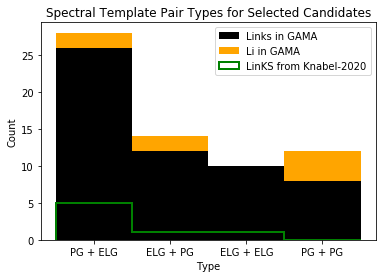

In [79]:
fig, ax = plt.subplots()
ax.hist([links_select_types.type_number, li_select_types.type_number],
        color = ['k','orange'],
         label = ['Links in GAMA', 'Li in GAMA'],
         stacked = True,
       align='mid',
       bins=4,
       range=(0.5, 4.5))
ax.hist([links_knabel_select_types.type_number],
        edgecolor='g',
        histtype='step',
        linewidth=2,
        label='LinKS from Knabel-2020',
        align='mid',
       bins=4,
       range=(0.5, 4.5))#,
        #align='mid')
ax.legend()
ax.set_xlabel('Type')
ax.set_xticks(np.arange(1, 5, 1))
ax.set_xticklabels(['PG + ELG', 'ELG + PG', 'ELG + ELG', 'PG + PG'])
ax.set_ylabel('Count')
ax.set_title('Spectral Template Pair Types for Selected Candidates')

#plt.savefig('/home/shawn/Desktop/links_autoz/visuals/png/template_pair_types_select.png')

Prepare samples for modeling by determining z_lens and z_source (and D_lens and D_source) from z1 and z2, correcting M* for z_lens where Z = z_source $$M_{*correct} = M_* (D_{source}^2/D_{lens}^2)$$

In [9]:
# load lambdar mass catalog
# import lambdarstellarmasses
# Opening GAMA data from G09, G12, and G15 (DR3)
hdul = fits.open('/data/sknabel/autoz_lens_model/files/fits/StellarMassesLambdar.fits')  # open a FITS file
hdul.verify('fix')
masses = hdul[1].data  # assume the first extension is a table
#print(masses.columns)



# create dataframe of masses objects to compare to candidates
GAMA_ID = masses.CATAID.byteswap().newbyteorder()
logmstar = masses.logmstar.byteswap().newbyteorder()
logmintsfh = masses.logmintsfh.byteswap().newbyteorder()
logmremnants = masses.logmremnants.byteswap().newbyteorder()
fluxscale = masses.fluxscale.byteswap().newbyteorder()
dellogmintsfh = masses.dellogmintsfh.byteswap().newbyteorder()
z = masses.Z.byteswap().newbyteorder()

#masses_list = list(zip(GAMA_ID, logmstar, logmintsfh, logmremnants, fluxscale))

#masses_list
lambdar_masses = pd.DataFrame(
    {'GAMA_ID' : GAMA_ID,
#     'logmstar' : logmstar, 
     'lambdar_log_mstar' : logmintsfh,
    'lambdar_mstar' : 10**(logmintsfh),
    'lambdar_log_mstar_error': dellogmintsfh,
    'z': z}
) 
#     'logmremnants' : logmremnants, 
#     'fluxscale' : fluxscale})
lambdar_masses.GAMA_ID = lambdar_masses.GAMA_ID.astype(int)
print(len(lambdar_masses))



120619


In [10]:
# merge with lambdar catalogs
links_lambdar = pd.merge(links_select_types, lambdar_masses, how = 'left', on = 'GAMA_ID')
links_knabel_lambdar = links_knabel_select_types#pd.merge(links_knabel_select_types, lambdar_masses, how = 'left', on = 'GAMA_ID')
# note: The csv I used here had already been merged with lambdarmasses
li_lambdar = pd.merge(li_select_types, lambdar_masses, how = 'left', on = 'GAMA_ID')
print(len(links_lambdar), len(links_knabel_lambdar), len(li_lambdar))
print(links_lambdar.lambdar_log_mstar)

56 7 8
0     11.614862
1     11.421960
2     11.428493
3     11.322670
4     11.662157
5     11.414567
6     11.473941
7     11.485850
8     11.308800
9     11.328982
10    11.553217
11    11.503013
12    11.503013
13    11.285226
14    11.506654
15    11.243180
16    11.623652
17    11.508179
18    11.405825
19    11.668818
20          NaN
21    11.488566
22    11.285226
23    11.489197
24    11.994014
25    11.375979
26    11.760890
27    11.434723
28    11.557787
29    11.472861
30    11.554252
31    11.470999
32    11.738676
33    11.252039
34    11.660450
35    11.510092
36    11.360675
37    11.633840
38    11.630485
39    11.422040
40    11.776137
41    11.252039
42    11.861844
43    11.508821
44    11.709104
45    11.709104
46    11.055600
47    11.528065
48    11.716955
49    11.716750
50    11.351500
51    11.563930
52    11.560124
53    11.486208
54    11.063362
55    11.518801
Name: lambdar_log_mstar, dtype: float32


In [11]:
# label z1 and z2 by the correct zlens and zsource
#links
z1 = links_lambdar.z1
z2 = links_lambdar.z2
z = links_lambdar.z
stellar_mass = links_lambdar.lambdar_mstar
sigma1 = links_lambdar.sigma1
sigma2 = links_lambdar.sigma2

#links_lambdar['zlens'] = 0
#links_lambdar['zsource'] = 0

zlens = []
zsource = []
sigma_lens = []
sigma_source = []
dlens = []
dsource = []
corrected_stellar_mass = []

for i in range(len(links_lambdar.z)):
    if (z1.iloc[i] < z2.iloc[i]) & (abs(z1.iloc[i] - z.iloc[i]) < 0.005): # if z1 is closer and matches to z
        #links_lambdar['zlens'].iloc[i] = z1.iloc[i]
        #links_lambdar['zsource'].iloc[i] = z2.iloc[i]
        zl = z1.iloc[i]
        zs = z2.iloc[i]
        sigma_l = sigma1.iloc[i]
        sigma_s = sigma2.iloc[i]
        dl = cosmo.angular_diameter_distance(zl).value
        ds = cosmo.angular_diameter_distance(zs).value
        m = stellar_mass.iloc[i]
        # append lists
        zlens.append(zl)
        zsource.append(zs)
        sigma_lens.append(sigma_l)
        sigma_source.append(sigma_s)
        dlens.append(dl)
        dsource.append(ds)
        corrected_stellar_mass.append(m)
    elif (z2.iloc[i] < z1.iloc[i]) & (abs(z2.iloc[i] - z.iloc[i]) < 0.005): # if z2 is closer and matches to z
        #links_lambdar['zlens'].iloc[i] = z2.iloc[i]
        #links_lambdar['zsource'].iloc[i] = z1.iloc[i]
        zl = z2.iloc[i]
        zs = z1.iloc[i]
        sigma_l = sigma2.iloc[i]
        sigma_s = sigma1.iloc[i]
        dl = cosmo.angular_diameter_distance(zl).value
        ds = cosmo.angular_diameter_distance(zs).value
        m = stellar_mass.iloc[i]
        # append lists
        zlens.append(zl)
        zsource.append(zs)
        sigma_lens.append(sigma_l)
        sigma_source.append(sigma_s)
        dlens.append(dl)
        dsource.append(ds)
        corrected_stellar_mass.append(m)        
    elif (z1.iloc[i] < z2.iloc[i]) & (abs(z2.iloc[i] - z.iloc[i]) < 0.005): # if z1 is closer, but z2 matches z
        #print(links_lambdar.GAMA_ID.iloc[i], 'is wonky.')
        zl = z1.iloc[i]
        zs = z2.iloc[i]
        sigma_l = sigma1.iloc[i]
        sigma_s = sigma2.iloc[i]
        dl = cosmo.angular_diameter_distance(zl).value
        ds = cosmo.angular_diameter_distance(zs).value
        m = stellar_mass.iloc[i] * ((dl**2)/(ds**2))
        # append lists
        zlens.append(zl)
        zsource.append(zs)
        sigma_lens.append(sigma_l)
        sigma_source.append(sigma_s)
        dlens.append(dl)
        dsource.append(ds)
        corrected_stellar_mass.append(m)
    elif (z2.iloc[i] < z1.iloc[i]) & (abs(z1.iloc[i] - z.iloc[i]) < 0.005): # if z2 is closer, but z1 matches z
        #print(links_lambdar.GAMA_ID.iloc[i], 'is wonky.')
        zl = z2.iloc[i]
        zs = z1.iloc[i]
        sigma_l = sigma2.iloc[i]
        sigma_s = sigma1.iloc[i]
        dl = cosmo.angular_diameter_distance(zl).value
        ds = cosmo.angular_diameter_distance(zs).value
        m = stellar_mass.iloc[i] * ((dl**2)/(ds**2))
        # append lists
        zlens.append(zl)
        zsource.append(zs)
        sigma_lens.append(sigma_l)
        sigma_source.append(sigma_s)
        dlens.append(dl)
        dsource.append(ds)
        corrected_stellar_mass.append(m)
    else:
        print(links_lambdar.GAMA_ID.iloc[i], 'is wonky.')
        # append lists
        zlens.append(np.nan)
        zsource.append(np.nan)
        sigma_lens.append(np.nan)
        sigma_source.append(np.nan)
        dlens.append(np.nan)
        dsource.append(np.nan)
        corrected_stellar_mass.append(np.nan)
        
        
links_lambdar['zlens'] = zlens
links_lambdar['zsource'] = zsource
links_lambdar['sigma_lens'] = sigma_lens
links_lambdar['sigma_source'] = sigma_source
links_lambdar['dlens'] = dlens
links_lambdar['dsource'] = dsource
links_lambdar['corrected_stellar_mass'] = corrected_stellar_mass

print(links_lambdar.columns)

##########
#links_knabel
# label z1 and z2 by the correct zlens and zsource
z1 = links_knabel_lambdar.z1
z2 = links_knabel_lambdar.z2
z = links_knabel_lambdar.z
stellar_mass = links_knabel_lambdar.lambdar_mstar
sigma1 = links_knabel_lambdar.sigma1
sigma2 = links_knabel_lambdar.sigma2

#links_knabel_lambdar['zlens'] = 0
#links_knabel_lambdar['zsource'] = 0

zlens = []
zsource = []
sigma_lens = []
sigma_source = []
dlens = []
dsource = []
corrected_stellar_mass = []

for i in range(len(links_knabel_lambdar.z)):
    if (z1.iloc[i] < z2.iloc[i]) & (abs(z1.iloc[i] - z.iloc[i]) < 0.005): # if z1 is closer and matches to z
        #links_knabel_lambdar['zlens'].iloc[i] = z1.iloc[i]
        #links_knabel_lambdar['zsource'].iloc[i] = z2.iloc[i]
        zl = z1.iloc[i]
        zs = z2.iloc[i]
        sigma_l = sigma1.iloc[i]
        sigma_s = sigma2.iloc[i]
        dl = cosmo.angular_diameter_distance(zl).value
        ds = cosmo.angular_diameter_distance(zs).value
        m = stellar_mass.iloc[i]
        # append lists
        zlens.append(zl)
        zsource.append(zs)
        sigma_lens.append(sigma_l)
        sigma_source.append(sigma_s)
        dlens.append(dl)
        dsource.append(ds)
        corrected_stellar_mass.append(m)
    elif (z2.iloc[i] < z1.iloc[i]) & (abs(z2.iloc[i] - z.iloc[i]) < 0.005): # if z2 is closer and matches to z
        #links_knabel_lambdar['zlens'].iloc[i] = z2.iloc[i]
        #links_knabel_lambdar['zsource'].iloc[i] = z1.iloc[i]
        zl = z2.iloc[i]
        zs = z1.iloc[i]
        sigma_l = sigma2.iloc[i]
        sigma_s = sigma1.iloc[i]
        dl = cosmo.angular_diameter_distance(zl).value
        ds = cosmo.angular_diameter_distance(zs).value
        m = stellar_mass.iloc[i]
        # append lists
        zlens.append(zl)
        zsource.append(zs)
        sigma_lens.append(sigma_l)
        sigma_source.append(sigma_s)
        dlens.append(dl)
        dsource.append(ds)
        corrected_stellar_mass.append(m)        
    elif (z1.iloc[i] < z2.iloc[i]) & (abs(z2.iloc[i] - z.iloc[i]) < 0.005): # if z1 is closer, but z2 matches z
        #print(links_knabel_lambdar.GAMA_ID.iloc[i], 'is wonky.')
        zl = z1.iloc[i]
        zs = z2.iloc[i]
        sigma_l = sigma1.iloc[i]
        sigma_s = sigma2.iloc[i]
        dl = cosmo.angular_diameter_distance(zl).value
        ds = cosmo.angular_diameter_distance(zs).value
        m = stellar_mass.iloc[i] * ((dl**2)/(ds**2))
        # append lists
        zlens.append(zl)
        zsource.append(zs)
        sigma_lens.append(sigma_l)
        sigma_source.append(sigma_s)
        dlens.append(dl)
        dsource.append(ds)
        corrected_stellar_mass.append(m)
    elif (z2.iloc[i] < z1.iloc[i]) & (abs(z1.iloc[i] - z.iloc[i]) < 0.005): # if z2 is closer, but z1 matches z
        #print(links_knabel_lambdar.GAMA_ID.iloc[i], 'is wonky.')
        zl = z2.iloc[i]
        zs = z1.iloc[i]
        sigma_l = sigma2.iloc[i]
        sigma_s = sigma1.iloc[i]
        dl = cosmo.angular_diameter_distance(zl).value
        ds = cosmo.angular_diameter_distance(zs).value
        m = stellar_mass.iloc[i] * ((dl**2)/(ds**2))
        # append lists
        zlens.append(zl)
        zsource.append(zs)
        sigma_lens.append(sigma_l)
        sigma_source.append(sigma_s)
        dlens.append(dl)
        dsource.append(ds)
        corrected_stellar_mass.append(m)
    else:
        print(links_knabel_lambdar.GAMA_ID.iloc[i], 'is wonky.')
        # append lists
        zlens.append(np.nan)
        zsource.append(np.nan)
        sigma_lens.append(np.nan)
        sigma_source.append(np.nan)
        dlens.append(np.nan)
        dsource.append(np.nan)
        corrected_stellar_mass.append(np.nan)
        
        
links_knabel_lambdar['zlens'] = zlens
links_knabel_lambdar['zsource'] = zsource
links_knabel_lambdar['sigma_lens'] = sigma_lens
links_knabel_lambdar['sigma_source'] = sigma_source
links_knabel_lambdar['dlens'] = dlens
links_knabel_lambdar['dsource'] = dsource
links_knabel_lambdar['corrected_stellar_mass'] = corrected_stellar_mass

print(links_knabel_lambdar.columns)

################
#li
# label z1 and z2 by the correct zlens and zsource
z1 = li_lambdar.z1
z2 = li_lambdar.z2
z = li_lambdar.z
stellar_mass = li_lambdar.lambdar_mstar
sigma1 = li_lambdar.sigma1
sigma2 = li_lambdar.sigma2

#li_lambdar['zlens'] = 0
#li_lambdar['zsource'] = 0

zlens = []
zsource = []
sigma_lens = []
sigma_source = []
dlens = []
dsource = []
corrected_stellar_mass = []

for i in range(len(li_lambdar.z)):
    if (z1.iloc[i] < z2.iloc[i]) & (abs(z1.iloc[i] - z.iloc[i]) < 0.005): # if z1 is closer and matches to z
        #li_lambdar['zlens'].iloc[i] = z1.iloc[i]
        #li_lambdar['zsource'].iloc[i] = z2.iloc[i]
        zl = z1.iloc[i]
        zs = z2.iloc[i]
        sigma_l = sigma1.iloc[i]
        sigma_s = sigma2.iloc[i]
        dl = cosmo.angular_diameter_distance(zl).value
        ds = cosmo.angular_diameter_distance(zs).value
        m = stellar_mass.iloc[i]
        # append lists
        zlens.append(zl)
        zsource.append(zs)
        sigma_lens.append(sigma_l)
        sigma_source.append(sigma_s)
        dlens.append(dl)
        dsource.append(ds)
        corrected_stellar_mass.append(m)
    elif (z2.iloc[i] < z1.iloc[i]) & (abs(z2.iloc[i] - z.iloc[i]) < 0.005): # if z2 is closer and matches to z
        #li_lambdar['zlens'].iloc[i] = z2.iloc[i]
        #li_lambdar['zsource'].iloc[i] = z1.iloc[i]
        zl = z2.iloc[i]
        zs = z1.iloc[i]
        sigma_l = sigma2.iloc[i]
        sigma_s = sigma1.iloc[i]
        dl = cosmo.angular_diameter_distance(zl).value
        ds = cosmo.angular_diameter_distance(zs).value
        m = stellar_mass.iloc[i]
        # append lists
        zlens.append(zl)
        zsource.append(zs)
        sigma_lens.append(sigma_l)
        sigma_source.append(sigma_s)
        dlens.append(dl)
        dsource.append(ds)
        corrected_stellar_mass.append(m)        
    elif (z1.iloc[i] < z2.iloc[i]) & (abs(z2.iloc[i] - z.iloc[i]) < 0.005): # if z1 is closer, but z2 matches z
        #print(li_lambdar.GAMA_ID.iloc[i], 'is wonky.')
        zl = z1.iloc[i]
        zs = z2.iloc[i]
        sigma_l = sigma1.iloc[i]
        sigma_s = sigma2.iloc[i]
        dl = cosmo.angular_diameter_distance(zl).value
        ds = cosmo.angular_diameter_distance(zs).value
        m = stellar_mass.iloc[i] * ((dl**2)/(ds**2))
        # append lists
        zlens.append(zl)
        zsource.append(zs)
        sigma_lens.append(sigma_l)
        sigma_source.append(sigma_s)
        dlens.append(dl)
        dsource.append(ds)
        corrected_stellar_mass.append(m)
    elif (z2.iloc[i] < z1.iloc[i]) & (abs(z1.iloc[i] - z.iloc[i]) < 0.005): # if z2 is closer, but z1 matches z
        #print(li_lambdar.GAMA_ID.iloc[i], 'is wonky.')
        zl = z2.iloc[i]
        zs = z1.iloc[i]
        sigma_l = sigma2.iloc[i]
        sigma_s = sigma1.iloc[i]
        dl = cosmo.angular_diameter_distance(zl).value
        ds = cosmo.angular_diameter_distance(zs).value
        m = stellar_mass.iloc[i] * ((dl**2)/(ds**2))
        # append lists
        zlens.append(zl)
        zsource.append(zs)
        sigma_lens.append(sigma_l)
        sigma_source.append(sigma_s)
        dlens.append(dl)
        dsource.append(ds)
        corrected_stellar_mass.append(m)
    else:
        print(li_lambdar.GAMA_ID.iloc[i], 'is wonky.')
        # append lists
        zlens.append(np.nan)
        zsource.append(np.nan)
        sigma_lens.append(np.nan)
        sigma_source.append(np.nan)
        dlens.append(np.nan)
        dsource.append(np.nan)
        corrected_stellar_mass.append(np.nan)
        
        
li_lambdar['zlens'] = zlens
li_lambdar['zsource'] = zsource
li_lambdar['sigma_lens'] = sigma_lens
li_lambdar['sigma_source'] = sigma_source
li_lambdar['dlens'] = dlens
li_lambdar['dsource'] = dsource
li_lambdar['corrected_stellar_mass'] = corrected_stellar_mass

print(li_lambdar.columns)

323152.0 is wonky.
Index(['Unnamed: 0_x', 'GAMA_ID', 'ID', 'RA', 'DEC', 'SCORE', 'Unnamed: 0_y',
       'z1', 'sigma1', 'template1', 'z2', 'sigma2', 'template2', 'sigma3',
       'sigma4', 'R', 'prob', 'error', 'type', 'lambdar_log_mstar',
       'lambdar_mstar', 'lambdar_log_mstar_error', 'z', 'zlens', 'zsource',
       'sigma_lens', 'sigma_source', 'dlens', 'dsource',
       'corrected_stellar_mass'],
      dtype='object')
Index(['Unnamed: 0_x', 'Unnamed: 0.1', 'GAMA_ID', 'RA', 'DEC', 'score', 'z',
       'magphys_mstar', 'lambdar_log_mstar', 'lambdar_mstar',
       'lambdar_log_mstar_error', 'm_half_re', 'sigma_star', 'D_lens',
       'theta_e_pm', 'theta_e_sis', 'Unnamed: 0_y', 'z1', 'sigma1',
       'template1', 'z2', 'sigma2', 'template2', 'sigma3', 'sigma4', 'R',
       'prob', 'error', 'type', 'zlens', 'zsource', 'sigma_lens',
       'sigma_source', 'dlens', 'dsource', 'corrected_stellar_mass'],
      dtype='object')
Index(['Unnamed: 0_x', 'name', 'KIDS_ID', 'RA', 'DEC', 'mag',

In [12]:
# deal with the wonky one (it doesn't have a lambdar match)
wonky_one = links_lambdar[links_lambdar['GAMA_ID']==323152.0]
wonky_one_index = links_lambdar[links_lambdar['GAMA_ID']==323152.0].index
zl = wonky_one.z2
zs = wonky_one.z1
sigma_l = wonky_one.sigma2
sigma_s = wonky_one.sigma1
dl = cosmo.angular_diameter_distance(zl).value
ds = cosmo.angular_diameter_distance(zs).value


links_lambdar.zlens[links_lambdar.GAMA_ID==323152.0] = zl
links_lambdar.zsource[links_lambdar.GAMA_ID==323152.0] = zs
links_lambdar.sigma_lens[links_lambdar.GAMA_ID==323152.0] = sigma_l
links_lambdar.sigma_source[links_lambdar.GAMA_ID==323152.0] = sigma_s
links_lambdar.dlens[links_lambdar.GAMA_ID==323152.0] = dl
links_lambdar.dsource[links_lambdar.GAMA_ID==323152.0] = ds
print(links_lambdar[links_lambdar.GAMA_ID==323152.0])

    Unnamed: 0_x   GAMA_ID      ID         RA      DEC  SCORE  Unnamed: 0_y  \
20             2  323152.0  2967.0  130.54643  1.64325   30.0       38855.0   

         z1    sigma1  template1        z2    sigma2  template2    sigma3  \
20  0.72159  11.31752       47.0  0.353286  7.519264       40.0  4.763242   

      sigma4         R      prob      error      type  lambdar_log_mstar  \
20  4.763242  1.578602  0.989458  29.413359  PG + ELG                NaN   

    lambdar_mstar  lambdar_log_mstar_error   z     zlens  zsource  sigma_lens  \
20            NaN                      NaN NaN  0.353286  0.72159    7.519264   

    sigma_source       dlens      dsource  corrected_stellar_mass  
20      11.31752  981.871392  1440.995427                     NaN  


/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value 

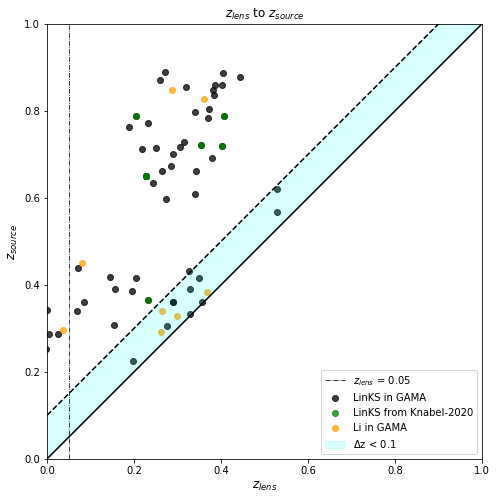

In [13]:
# check lens and source redshifts for reasonability
# plots
x = np.linspace(0, 1, 100)

fig = plt.figure(figsize=(8,8))
ax = plt.subplot()
#ax.set_xlim(0, 1)
#ax.set_ylim(0, 0.8)
ax.scatter(links_lambdar.zlens,
          links_lambdar.zsource,
          color = 'k',
          marker = 'o',
          alpha = 0.75,
          label = 'LinKS in GAMA')
ax.scatter(links_knabel_lambdar.zlens,
           links_knabel_lambdar.zsource,
          color = 'g',
          marker = 'o',
          alpha = 0.75,
          label = 'LinKS from Knabel-2020')
ax.scatter(li_lambdar.zlens,
           li_lambdar.zsource,
          color = 'orange',
          marker = 'o',
          alpha = 0.75,
          label = 'Li in GAMA')
#ax.add_patch(patches.Rectangle((1.85, 4.5), 2, 10, 
 #                              edgecolor = 'k', facecolor = 'none', linestyle = ':',
  #                            label = 'Holwerda-15 Selection'))
#ax.axvline(1.2, color = 'k', linewidth = .75, linestyle = '--', label = 'R = 1.2')
ax.set_xlabel('$z_{lens}$', fontsize = 12)
ax.set_ylabel('$z_{source}$',  fontsize = 12)
ax.set_title('$z_{lens}$ to $z_{source}$')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect(1)
ax.plot(x, x, color = 'k', linestyle = '-')
ax.plot(x, x + 0.1, color = 'k', linestyle = '--')
#ax.plot(x, x - 0.1, color = 'k', linestyle = '--')
plt.fill_between(x, x, x+0.1, # Fill region for false candidates
                 facecolor="cyan", # The fill color
                 color='cyan',       # The outline color
                 alpha=0.15, # Transparency of the fill
                label='$\Delta$z < 0.1') # plots
x = np.linspace(0, 1, 100)


#ax.set_xlim(0, 1)
#ax.set_ylim(0, 0.8)

#ax.add_patch(patches.Rectangle((1.85, 4.5), 2, 10, 
 #                              edgecolor = 'k', facecolor = 'none', linestyle = ':',
  #                            label = 'Holwerda-15 Selection'))
ax.axvline(0.05, color = 'k', linewidth = .75, linestyle = '-.', label = '$z_{lens}$ = 0.05')

plt.legend()
#plt.show()

#plt.savefig('/home/shawn/Desktop/links_autoz/visuals/png/zlens_to_zsource_061520.png')


In [14]:
# take candidates with z_lens > 0.05 and delta-z > 0.1
li_redshift_cut = li_lambdar[(li_lambdar.zsource - li_lambdar.zlens > 0.1) 
                             & (li_lambdar.zlens > 0.05)]
links_redshift_cut = links_lambdar[(links_lambdar.zsource - links_lambdar.zlens > 0.1) 
                                   & (links_lambdar.zlens > 0.05)]
links_knabel_redshift_cut = links_knabel_lambdar[(links_knabel_lambdar.zsource - links_knabel_lambdar.zlens > 0.1) 
                                                 & (links_knabel_lambdar.zlens > 0.05)]

print(len(li_lambdar), len(links_lambdar), len(links_knabel_lambdar))
print(len(li_redshift_cut), len(links_redshift_cut), len(links_knabel_redshift_cut))
#print(li_lambdar.zlens, links_lambdar.zlens, links_knabel_lambdar.zlens)
#print(li_redshift_cut.zlens, links_redshift_cut.zlens, links_knabel_redshift_cut.zlens)

8 56 7
3 42 7


In [15]:
# examine duplicates in links
links_duplicates = links_redshift_cut[links_redshift_cut.duplicated(subset=['GAMA_ID'], keep=False)]
print(links_duplicates)
links_knabel_duplicates = links_knabel_redshift_cut[links_knabel_redshift_cut.GAMA_ID.duplicated(keep=False)]
print(links_knabel_duplicates)

    Unnamed: 0_x   GAMA_ID      ID         RA      DEC  SCORE  Unnamed: 0_y  \
13           316  544226.0  3212.0  214.42336 -0.89247   18.0       94759.0   
22           316  544226.0  3212.0  214.42336 -0.89247   18.0      154300.0   
33           329  262874.0    26.0  221.61067  2.22389   12.0      159395.0   
41           329  262874.0    26.0  221.61067  2.22389   12.0      139125.0   

          z1    sigma1  template1        z2    sigma2  template2    sigma3  \
13  0.227044  9.393048       40.0  0.649824  7.239896       46.0  3.411552   
22  0.649852  6.409822       47.0  0.227039  6.293928       40.0  3.835091   
33  0.385518  9.339182       40.0  0.194628  4.816656       47.0  3.402748   
41  0.385581  6.221604       40.0  0.858924  3.421708       41.0  2.811662   

      sigma4         R      prob      error       type  lambdar_log_mstar  \
13  3.411552  2.122170  0.996206  45.355965   PG + ELG          11.285226   
22  3.835091  1.641142  0.366429  39.200554   PG + ELG     

### G544226 has two entries.
    Each show PG at z=0.22 and ELG at z=0.65.
    Cross-correlation sigma is higher for each for the one indexed at 13 (48 in knabel), as is R.
    Index 22 shows a higher sigma for the source than the lens, in effect getting them backwards.
    For the above reasons I will keep Index 13 (48).
### G262874 has two entries.
    Both show z1 to be a PG at z=0.38.
    Index 33 shows the second match at closer redshift as an ELG+PG.
    Index 41 is the more reasonable one.

In [16]:
links_dropped_duplicates = links_redshift_cut.drop(index=[22, 33])
links_knabel_dropped_duplicates = links_knabel_redshift_cut.drop(index=[49])
print(len(links_dropped_duplicates), len(links_knabel_dropped_duplicates))

40 6


### This is the most recent selection of candidate lenses, including cuts based on autoz output, redshifts, and duplicates.
### LinKS: 40 (including 6 from Knabel-2020)
### Li: 3
## Total of 43 candidates to pursue.

In [82]:
# Reassign consistent naming scheme
links_selected_sample = links_dropped_duplicates
links_knabel_selected_sample = links_knabel_dropped_duplicates
li_selected_sample = li_redshift_cut

print(len(links_selected_sample), len(links_knabel_selected_sample), len(li_selected_sample))
print(links_selected_sample.columns, 
      links_knabel_selected_sample.columns, 
      li_selected_sample.columns)

40 6 3
Index(['Unnamed: 0_x', 'GAMA_ID', 'ID', 'RA', 'DEC', 'SCORE', 'Unnamed: 0_y',
       'z1', 'sigma1', 'template1', 'z2', 'sigma2', 'template2', 'sigma3',
       'sigma4', 'R', 'prob', 'error', 'type', 'lambdar_log_mstar',
       'lambdar_mstar', 'lambdar_log_mstar_error', 'z', 'zlens', 'zsource',
       'sigma_lens', 'sigma_source', 'dlens', 'dsource',
       'corrected_stellar_mass'],
      dtype='object') Index(['Unnamed: 0_x', 'Unnamed: 0.1', 'GAMA_ID', 'RA', 'DEC', 'score', 'z',
       'magphys_mstar', 'lambdar_log_mstar', 'lambdar_mstar',
       'lambdar_log_mstar_error', 'm_half_re', 'sigma_star', 'D_lens',
       'theta_e_pm', 'theta_e_sis', 'Unnamed: 0_y', 'z1', 'sigma1',
       'template1', 'z2', 'sigma2', 'template2', 'sigma3', 'sigma4', 'R',
       'prob', 'error', 'type', 'zlens', 'zsource', 'sigma_lens',
       'sigma_source', 'dlens', 'dsource', 'corrected_stellar_mass'],
      dtype='object') Index(['Unnamed: 0_x', 'name', 'KIDS_ID', 'RA', 'DEC', 'mag', 'mag_err',


### Visualization

Text(0.5, 1.0, 'Redshift Success Probability')

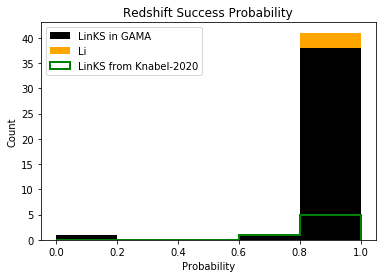

In [80]:
# redshift success probability
plt.hist([links_selected_sample.prob, li_selected_sample.prob],
        color = ['k', 'orange'],
         label = ['LinKS in GAMA', 'Li'],
         stacked = True,
        bins=np.linspace(0,1,6))#, density = True)
plt.hist(links_knabel_selected_sample.prob,
        color = 'g',
         label = 'LinKS from Knabel-2020',
        histtype='step',
         linewidth=2,
        bins=np.linspace(0,1,6))#, density = True)
plt.legend(),
plt.xlabel('Probability')
plt.ylabel('Count')
plt.title('Redshift Success Probability')

#plt.savefig('/home/shawn/Desktop/links_autoz/visuals/png/z_success_probability_select.png')

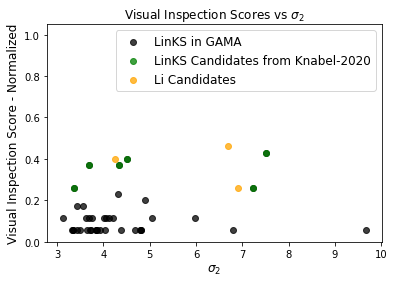

In [88]:
# visual inspection score to sigma2

fig = plt.figure()#figsize=(8,6))
ax = plt.subplot()
#ax.set_xlim(0., 2.5)
ax.set_ylim(0, 1.05)
ax.scatter(#links.R,
          links_selected_sample.sigma2,
    links_selected_sample.SCORE/70.,
          color = 'k',
          marker = 'o',
          alpha = 0.75,
          label = 'LinKS in GAMA')
ax.scatter(#links_identified.R,
           links_knabel_selected_sample.sigma2,
    links_knabel_selected_sample.score/70.,
          color = 'g',
          marker = 'o',
          alpha = 0.75,
          label = 'LinKS Candidates from Knabel-2020')

ax.scatter(#li.R,
           li_selected_sample.sigma2,
    li_selected_sample.score/10.,
          color = 'orange',
          marker = 'o',
          alpha = 0.75,
          label = 'Li Candidates')

#x.add_patch(patches.Rectangle((1.85, 4.5), 2, 10, 
 #                              edgecolor = 'k', facecolor = 'none', linestyle = ':',
  #                            label = 'Holwerda-15 Selection'))
#ax.axvline(1.2, color = 'k', linewidth = .75, linestyle = '--', label = 'R = 1.2')
ax.set_ylabel('Visual Inspection Score - Normalized', fontsize = 12)
ax.set_xlabel('$\sigma_2$',  fontsize = 12)
ax.set_title('Visual Inspection Scores vs $\sigma_2$')
plt.legend(fontsize=12)
#plt.show()

#plt.savefig('/home/shawn/Desktop/links_autoz/visuals/png/visual_score_to_sigma2_061620.png')

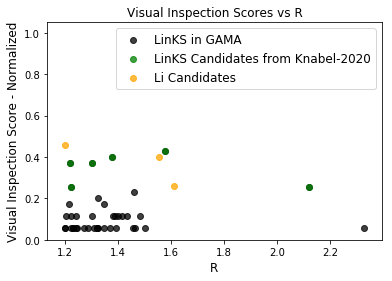

In [89]:
# visual inpsection score to R

fig = plt.figure()#figsize=(8,6))
ax = plt.subplot()
#ax.set_xlim(0., 2.5)
ax.set_ylim(0, 1.05)
ax.scatter(links_selected_sample.R,
          #links.sigma2,
    links_selected_sample.SCORE/70.,
          color = 'k',
          marker = 'o',
          alpha = 0.75,
          label = 'LinKS in GAMA')
ax.scatter(links_knabel_selected_sample.R,
           #links_knabel.sigma2,
    links_knabel_selected_sample.score/70.,
          color = 'g',
          marker = 'o',
          alpha = 0.75,
          label = 'LinKS Candidates from Knabel-2020')
ax.scatter(li_selected_sample.R,
           #li.sigma2,
    li_selected_sample.score/10.,
          color = 'orange',
          marker = 'o',
          alpha = 0.75,
          label = 'Li Candidates')

#x.add_patch(patches.Rectangle((1.85, 4.5), 2, 10, 
 #                              edgecolor = 'k', facecolor = 'none', linestyle = ':',
  #                            label = 'Holwerda-15 Selection'))
#ax.axvline(1.2, color = 'k', linewidth = .75, linestyle = '--', label = 'R = 1.2')
ax.set_ylabel('Visual Inspection Score - Normalized', fontsize = 12)
ax.set_xlabel('R',  fontsize = 12)
ax.set_title('Visual Inspection Scores vs R')
plt.legend(fontsize=12)
#plt.show()

#plt.savefig('/home/shawn/Desktop/links_autoz/visuals/png/visual_score_to_R_061620.png')

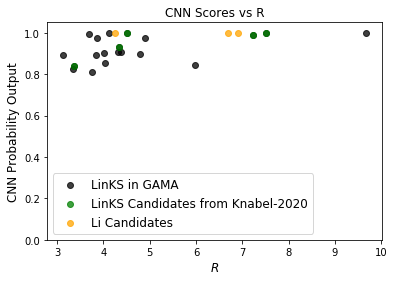

In [93]:
# CNN probability score vs sigma2

# merge with raw LinKS data to get the CNN probability output data
links_raw = pd.read_csv(f'{knabel2020_file_path}linkstable_trimmed.csv')
links_selected_sample = pd.merge(links_selected_sample, links_raw, how='left')
links_knabel_selected_sample = pd.merge(links_knabel_selected_sample, links_raw, how='left')

#print(links_selected_sample.columns, links_knabel_selected_sample.columns)


fig = plt.figure()#figsize=(8,6))
ax = plt.subplot()
#ax.set_xlim(0., 2.5)
ax.set_ylim(0, 1.05)
ax.scatter(links_selected_sample.sigma2,
          #links.sigma2,
    links_selected_sample.P1,
          color = 'k',
          marker = 'o',
          alpha = 0.75,
          label = 'LinKS in GAMA')
ax.scatter(links_knabel_selected_sample.sigma2,
           #links_knabel.sigma2,
    links_knabel_selected_sample.P1,
          color = 'g',
          marker = 'o',
          alpha = 0.75,
          label = 'LinKS Candidates from Knabel-2020')

ax.scatter(li_selected_sample.sigma2,
           #li.sigma2,
    li_selected_sample.probability,
          color = 'orange',
          marker = 'o',
          alpha = 0.75,
          label = 'Li Candidates')

#x.add_patch(patches.Rectangle((1.85, 4.5), 2, 10, 
 #                              edgecolor = 'k', facecolor = 'none', linestyle = ':',
  #                            label = 'Holwerda-15 Selection'))
#ax.axvline(1.2, color = 'k', linewidth = .75, linestyle = '--', label = 'R = 1.2')
ax.set_ylabel('CNN Probability Output', fontsize = 12)
ax.set_xlabel('$R$',  fontsize = 12)
ax.set_title('CNN Scores vs R')
plt.legend(fontsize=12)
#plt.show()

#plt.savefig('/home/shawn/Desktop/links_autoz/visuals/png/cnn_score_to_R_061620.png')

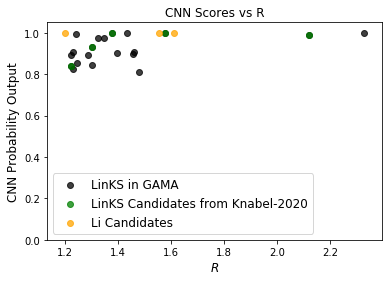

In [94]:
# CNN probability scores vs R

fig = plt.figure()#figsize=(8,6))
ax = plt.subplot()
#ax.set_xlim(0., 2.5)
ax.set_ylim(0, 1.05)
ax.scatter(links_selected_sample.R,
          #links.sigma2,
    links_selected_sample.P1,
          color = 'k',
          marker = 'o',
          alpha = 0.75,
          label = 'LinKS in GAMA')
ax.scatter(links_knabel_selected_sample.R,
           #links_knabel.sigma2,
    links_knabel_selected_sample.P1,
          color = 'g',
          marker = 'o',
          alpha = 0.75,
          label = 'LinKS Candidates from Knabel-2020')

ax.scatter(li_selected_sample.R,
           #li.sigma2,
    li_selected_sample.probability,
          color = 'orange',
          marker = 'o',
          alpha = 0.75,
          label = 'Li Candidates')

#x.add_patch(patches.Rectangle((1.85, 4.5), 2, 10, 
 #                              edgecolor = 'k', facecolor = 'none', linestyle = ':',
  #                            label = 'Holwerda-15 Selection'))
#ax.axvline(1.2, color = 'k', linewidth = .75, linestyle = '--', label = 'R = 1.2')
ax.set_ylabel('CNN Probability Output', fontsize = 12)
ax.set_xlabel('$R$',  fontsize = 12)
ax.set_title('CNN Scores vs R')
plt.legend(fontsize=12)
#plt.show()

#plt.savefig('/home/shawn/Desktop/links_autoz/visuals/png/cnn_score_to_R_061620.png')

In [99]:
# z1, z2, mass, type?
#from mpl_toolkits.mplot3d import Axes

#fig = plt.figure(figsize=(8,8))
#ax = plt.axes(projection='3d')
#ax.set_zlim(0, 12)
#ax.scatter3D(xs=spec.lambdar_log_mstar, ys=spec.z_lens, zs=spec.theta_e_pm/spec.theta_e_sis,
          #label='GAMA Spectroscopy Candidates',
          #color = 'b')

#ax.set_xticks(np.arange(10**9, 10**12, 10**11))
#ax.set_xticks(labels=None)
#for label in ax.get_xticklabels():
#    label.set_visible(False)
#ax.set_ylabel('Lens Redshift')
#ax.set_zlabel('Ratio of Estimates $\Theta_{E,TL}/\Theta_{E,SIS}$')
#ax.view_init(0, 90)